In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ConvNeXtLarge
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 98% 338M/346M [00:04<00:00, 69.0MB/s]
100% 346M/346M [00:04<00:00, 79.6MB/s]


In [3]:
# Set image size and batch size (adjust as needed)
IMG_SIZE = (224, 224)  # ConvNextLarge default input size
BATCH_SIZE = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Assuming you want a train-validation split
)

train_generator = train_datagen.flow_from_directory(
    '/content/seg_train/seg_train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/seg_test/seg_test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 11230 images belonging to 6 classes.
Found 598 images belonging to 6 classes.


In [4]:
# Load the ConvNeXtLarge model with pre-trained weights, exclude top layers
convnext_base = ConvNeXtLarge(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

785596384/785596384 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [5]:
# Freeze the base model
convnext_base.trainable = False

# Build the full model
model = models.Sequential([
    convnext_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),  # Custom dense layer
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer for classification
])

In [6]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Adjust the number of epochs as needed
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 325s 860ms/step - accuracy: 0.3706 - loss: 1.5766 - val_accuracy: 0.6171 - val_loss: 0.9950
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 285s 806ms/step - accuracy: 0.6222 - loss: 0.9579 - val_accuracy: 0.6856 - val_loss: 0.8533
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 322s 803ms/step - accuracy: 0.6514 - loss: 0.8593 - val_accuracy: 0.6890 - val_loss: 0.7805
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 283s 798ms/step - accuracy: 0.6766 - loss: 0.8047 - val_accuracy: 0.6806 - val_loss: 0.7821
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 284s 800ms/step - accuracy: 0.6856 - loss: 0.7840 - val_accuracy: 0.7007 - val_loss: 0.7625
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 322s 800ms/step - accuracy: 0.7075 - loss: 0.7356 - val_accuracy: 0.6823 - val_loss: 0.7699
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 322s 802ms/step - accuracy: 0.7081 - loss: 0.7324 - val_accuracy: 0.7324 - val_loss: 0.7190
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 282s 798ms/step - accuracy: 0.7299 - loss: 0.69

In [15]:
# # Save the model
# model.save('convnextlarge_finetuned.h5')

In [10]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 756ms/step - accuracy: 0.7523 - loss: 0.6518
Validation Accuracy: 74.75%


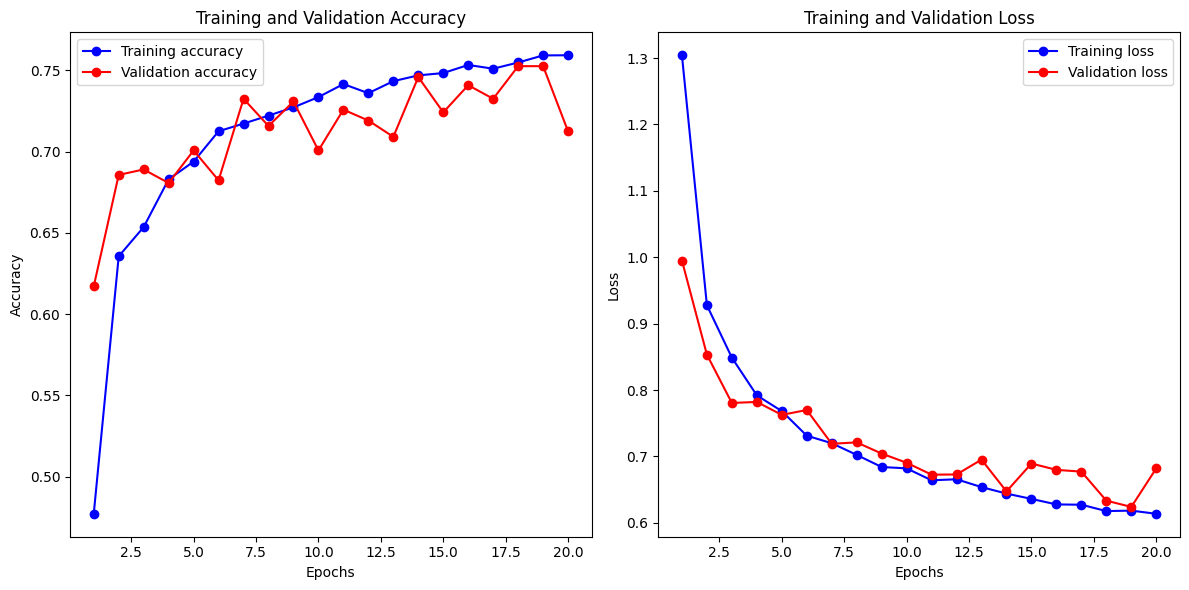

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the graphs
plot_training_history(history)

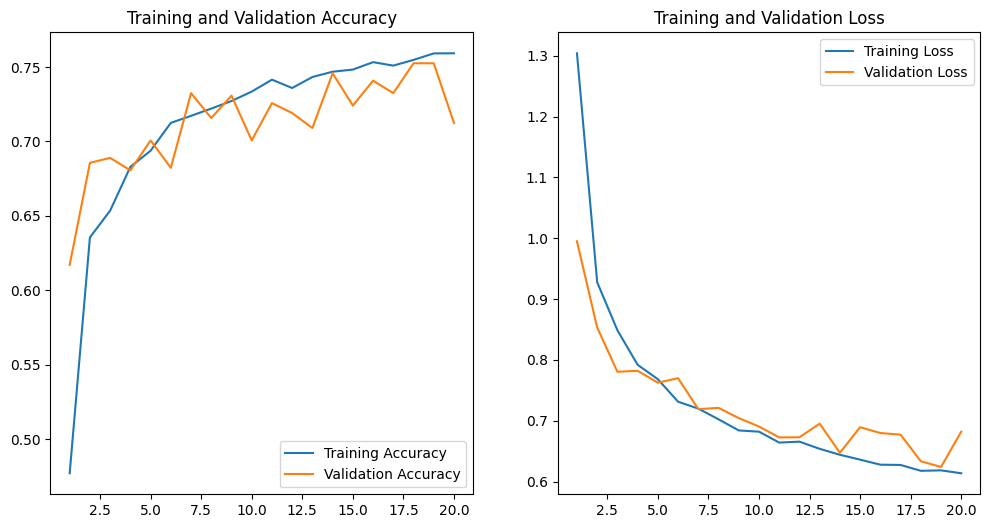

In [14]:
# Plotting accuracy and loss over epochs

# Retrieve accuracy and loss from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the plots
plt.show()